In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

df = pd.read_csv('cleaned/cleaned_data.csv')

Mean of TradeValue: 181161.76987179488


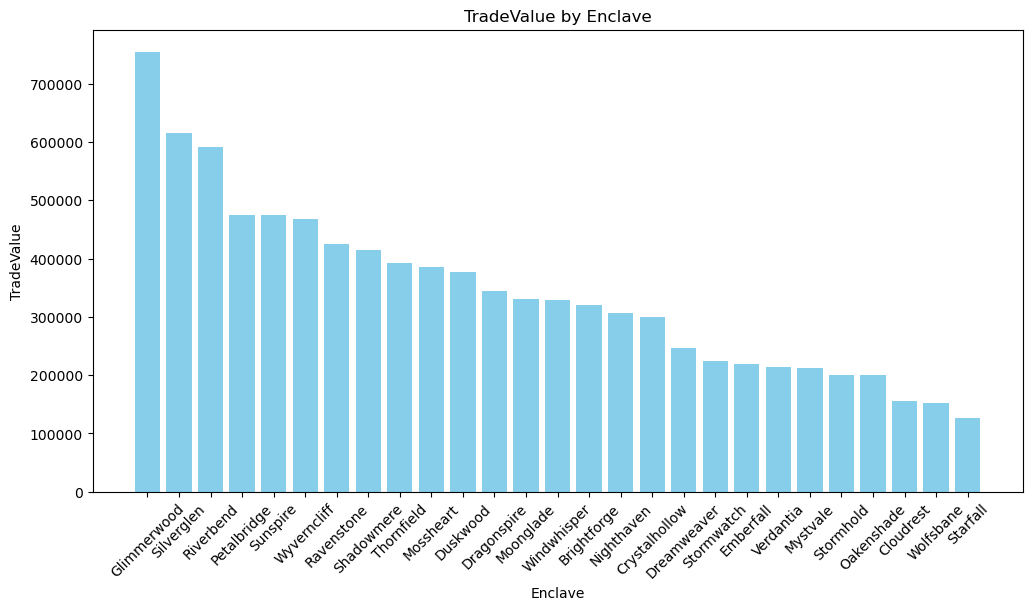

        DI  TradeValue     RealmType        Enclave  LivingQuarters     ParcelSize ParcelSizeUnit  StructuralIntegrity ExteriorCharm
0        0    269500.0   Meadowlands    Brightforge          2143.0    7939.000000           sqft                    5        Common
1        1    184900.0   Meadowlands    Brightforge           923.0   10083.000000           sqft                    5      Gleaming
2        2     87000.0  GnomeBurough    Petalbridge           959.0    9439.000000           sqft                    5        Common
3        3    130000.0   Meadowlands     Shadowmere           798.0    3869.000000           sqft                    6      Gleaming
4        4    144000.0   Meadowlands    Dragonspire          1172.0   11344.000000           sqft                    5        Common
5        5    174500.0   Meadowlands     Thornfield          1203.0   12000.000000           sqft                    7        Common
6        6    264500.0   AetherIsles    Wyverncliff          1412.0  

In [87]:
# Calculate the mean of the 'TradeValue' column
trade_value_mean = df['TradeValue'].mean()
print(f"Mean of TradeValue: {trade_value_mean}")

# Sort the 'TradeValue' column
sorted_trade_values = df.sort_values(by='TradeValue', ascending=False)

x = sorted_trade_values['Enclave']
y = sorted_trade_values['TradeValue']

plt.figure(figsize=(12, 6))
plt.bar(x, y, color='skyblue')
plt.xlabel('Enclave')
plt.ylabel('TradeValue')
plt.title('TradeValue by Enclave')
plt.xticks(rotation=45)
plt.show()

print(df.to_string())

<h1> First we check what values are given </h1>

**With these values, we define our**:

- **Monthly Income**
- **Monthly Available Funds**
- **Downpayment**
- **Loan Amount**
- **Total Payments**
- **Monthly Interest Rates**
- **Monthly Payments**

Then with the forumla we define the afordability and append that to the result[], array
And then we put the affordability into a new dataframe and make a new file called ifAffordable.csv

In [88]:
import pandas as pd
import os

# Given values
Income = 30000
interest_rate_per_year = 0.04
loan_term_years = 30
downpayment_percentage = 0.20

# Calculate monthly available funds (30% of monthly income)
monthly_income = Income / 12
monthly_available_funds = 0.30 * monthly_income

# List to store results
results = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    trade_value = row['TradeValue']
    
    downpayment = downpayment_percentage * trade_value
    loan_amount = trade_value - downpayment
    total_payments = loan_term_years * 12
    monthly_interest_rate = interest_rate_per_year / 12
    monthly_payment = (loan_amount * monthly_interest_rate * (1 + monthly_interest_rate) ** total_payments) / ((1 + monthly_interest_rate) ** total_payments - 1)
    
    # Determine if the home is affordable
    is_affordable = 1 if monthly_payment <= monthly_available_funds else 0
    
    # Append result
    results.append({
        'TradeValue': trade_value,
        'AffordableDwelling': is_affordable
    })

# Merge affordability results back into df
affordable_df = pd.DataFrame(results)
df = df.merge(affordable_df, on='TradeValue', how='left')

# === NEW PART: Add IsAffordable and EnclaveCategory columns ===

# Step 1: Calculate IsAffordable using the monthly payment directly
df["LoanAmount"] = df["TradeValue"] * 0.8
r = interest_rate_per_year / 12
n = loan_term_years * 12
df["MonthlyPayment"] = (df["LoanAmount"] * r * (1 + r) ** n) / ((1 + r) ** n - 1)
df["IsAffordable"] = (df["MonthlyPayment"] <= monthly_available_funds).astype(int)

# Step 2: Calculate Enclave Affordability Rate
enclave_affordability = df.groupby("Enclave")["AffordableDwelling"].mean()
df["EnclaveAffordabilityRate"] = df["Enclave"].map(enclave_affordability)

# Step 3: Categorize Enclave based on threshold
def categorize(rate):
    if rate >= 0.9:
        return "High"
    elif rate >= 0.5:
        return "Mid"
    else:
        return "Low"

df["EnclaveCategory"] = df["EnclaveAffordabilityRate"].apply(categorize)

# Save cleaned dataset
os.makedirs('cleaned', exist_ok=True)
df.to_csv('cleaned/ifAffordable.csv', index=False)


- **Now we check whether an enclave has a high or low affordability rate.**  
  This is our first rule because we want to determine if a dwelling in a certain enclave has a high chance of being **affordable** or **not affordable**.


Enclave Affordability Statistics:
          Enclave     RealmType  AffordabilityRate  Count  \
25      Wolfsbane  GnomeBurough           1.000000    113   
18       Starfall  GnomeBurough           1.000000    110   
1       Cloudrest   Meadowlands           1.000000    176   
6       Emberfall   Meadowlands           0.999045   1047   
10       Mystvale  GnomeBurough           0.985782    422   
20     Stormwatch  GnomeBurough           0.982704    636   
3     Dragonspire   Meadowlands           0.976759   3055   
13    Petalbridge  GnomeBurough           0.969880   1494   
16     Shadowmere   Meadowlands           0.953452   1289   
19      Stormhold   Meadowlands           0.950685    365   
23      Verdantia   Meadowlands           0.948276     58   
2   Crystalhollow   Meadowlands           0.900000    710   
5        Duskwood   Meadowlands           0.866265    830   
12     Oakenshade  GnomeBurough           0.818182     77   
0     Brightforge   Meadowlands           0.797386 

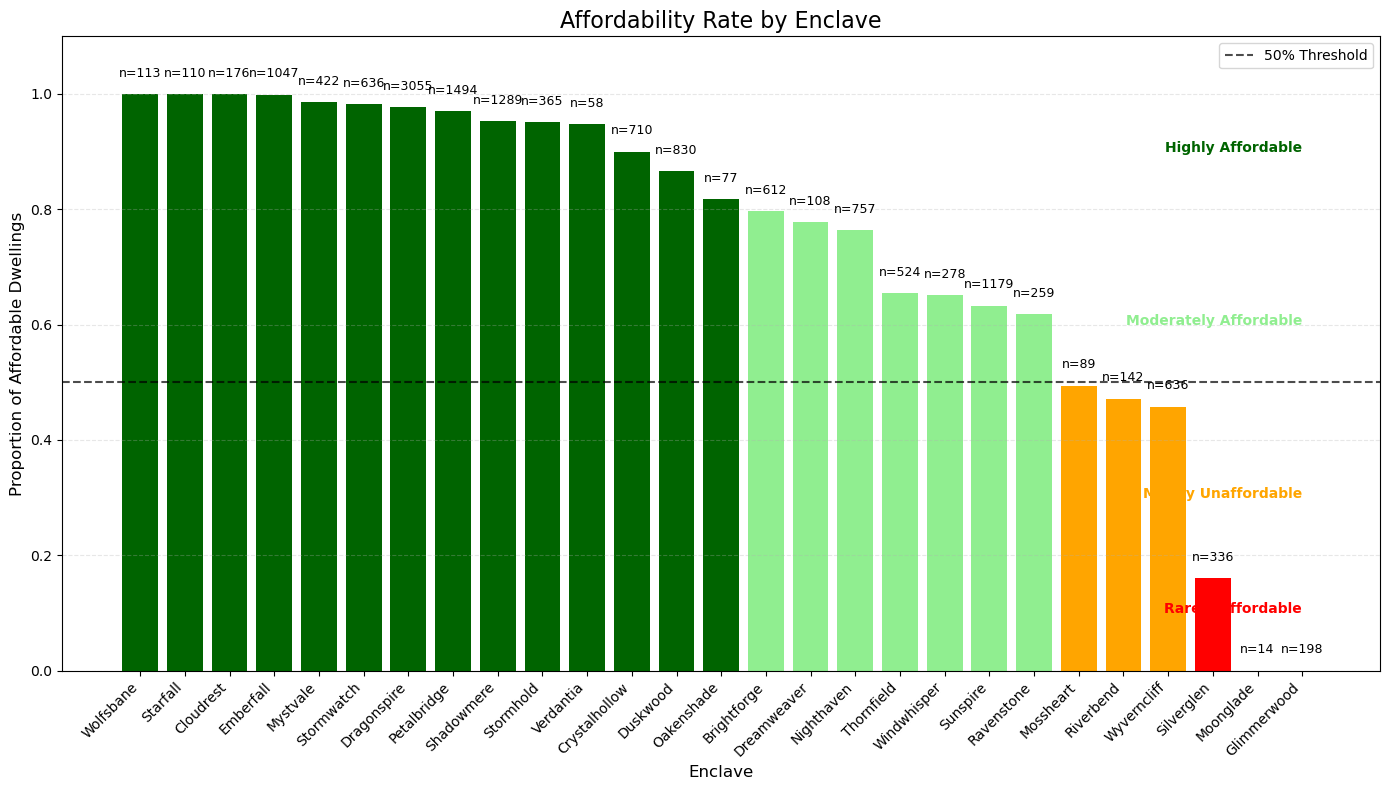

In [89]:
# Load the data
df = pd.read_csv('cleaned/ifAffordable.csv')

# Calculate affordability rate and count by enclave
enclave_stats = df.groupby('Enclave')['AffordableDwelling'].agg(['mean', 'count']).reset_index()
enclave_stats.columns = ['Enclave', 'AffordabilityRate', 'Count']
enclave_stats = enclave_stats.sort_values('AffordabilityRate', ascending=False)

# Create a color palette based on affordability rate
colors = ['darkgreen' if rate >= 0.8 else 
          'lightgreen' if rate >= 0.5 else 
          'orange' if rate >= 0.2 else 
          'red' for rate in enclave_stats['AffordabilityRate']]

# Create the plot
plt.figure(figsize=(14, 8))
bars = plt.bar(enclave_stats['Enclave'], enclave_stats['AffordabilityRate'], color=colors)

# Add count annotations to see how many dwellings are in each enclave and set the color of the text
for i, row in enumerate(enclave_stats.itertuples()):
    plt.text(i, row.AffordabilityRate + 0.03, f"n={row.Count}", ha='center', fontsize=9)

# Add threshold line at 0.5 (50% affordable), we do this so we can easily see which enclaves are above or below this threshold.
# We chose this threshold because it is the median of the affordability rate.
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, label='50% Threshold')

# Add category labels for better visualization and understanding
plt.text(len(enclave_stats)-1, 0.9, "Highly Affordable", ha='right', color='darkgreen', fontweight='bold')
plt.text(len(enclave_stats)-1, 0.6, "Moderately Affordable", ha='right', color='lightgreen', fontweight='bold')
plt.text(len(enclave_stats)-1, 0.3, "Mostly Unaffordable", ha='right', color='orange', fontweight='bold')
plt.text(len(enclave_stats)-1, 0.1, "Rarely Affordable", ha='right', color='red', fontweight='bold')

# Enhance the plot with labels and grid
plt.title('Affordability Rate by Enclave', fontsize=16)
plt.ylabel('Proportion of Affordable Dwellings', fontsize=12)
plt.xlabel('Enclave', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.legend()

# Add realm type information
# We do this because we want to color the bars based on the realm type of the enclave
enclave_realm = df[['Enclave', 'RealmType']].drop_duplicates().set_index('Enclave')
realm_colors = {'GnomeBurough': 'green', 'Meadowlands': 'blue', 'AetherIsles': 'purple'}

# Print table with affordability statistics
print("Enclave Affordability Statistics:")
summary_table = enclave_stats.copy()
summary_table['RealmType'] = summary_table['Enclave'].map(enclave_realm['RealmType'])

# We decided on certain thresholds to categorize the affordability rate
# These thresholds are based on the affordability rate
summary_table['AffordabilityCategory'] = pd.cut(
    summary_table['AffordabilityRate'],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Rarely Affordable', 'Mostly Unaffordable', 'Moderately Affordable', 'Highly Affordable'],
    include_lowest=True
)
print(summary_table[['Enclave', 'RealmType', 'AffordabilityRate', 'Count', 'AffordabilityCategory']])

plt.show()

# Simple Enclave-Based Affordability Model

## Overview

We created a simple affordability model based on the affordability rate in certain enclaves because some areas have consistently higher or lower housing affordability. This allows us to establish a quick benchmark for classifying dwellings as affordable or not based on location trends.

## Model Logic

The model uses a single rule:
- If a property is located in one of the enclaves with >50% affordability rate, classify it as affordable
- Otherwise, classify it as unaffordable

### List of Affordable Enclaves (>50% Affordability Rate)
1. Petalbridge
2. Starfall
3. Stormwatch
4. Mystvale
5. Cloudrest
6. Wolfsbane
7. Crystalhollow
8. Dragonspire
9. Shadowmere
10. Thornfield
11. Brightforge
12. Duskwood
13. Sunspire
14. Wyverncliff
15. Nighthaven
16. Emberfall
17. Dreamweaver
18. Silverglen
19. Riverbend
20. Ravenstone

## Implementation


We assign the affordable enclaves to a list and give it a 1 for affordable and 0 for not affordable

In [90]:
def simple_affordability_model(row):
    # Enclaves with >50% affordability rate
    affordable_enclaves = [
        'Petalbridge', 'Starfall', 'Stormwatch', 'Mystvale', 'Cloudrest',
        'Wolfsbane', 'Crystalhollow', 'Dragonspire', 'Shadowmere',
        'Thornfield', 'Brightforge', 'Duskwood', 'Sunspire',
        'Wyverncliff', 'Nighthaven', 'Emberfall', 'Dreamweaver',
        'Silverglen', 'Riverbend', 'Ravenstone',
    ]
    # Simple rule: classify based only on enclave(1 affordable, 0 not affordable)
    if row['Enclave'] in affordable_enclaves:
        return 1
    else:
        return 0

# here we check our accuracy of the model
df['SimpleModelPrediction'] = df.apply(simple_affordability_model, axis=1)
accuracy = accuracy_score(df['AffordableDwelling'], df['SimpleModelPrediction'])
print(f"Accuracy: {accuracy}")




Accuracy: 0.8190021915689055


## As you can see an accuracy of 0.8 is not bad at all, but we want to improve this accuracy by adding more rules.

### We will add several rules to improve our accuracy
### We will explain every rule by adding comments above the code

In [91]:
def improved_affordability_model(row):
    # RULE 1: BASE AFFORDABILITY CLASSIFICATION BY ENCLAVE CATEGORY
    # Enclaves are categorized into different affordability levels based on historical affordability rates.
    # This is the primary rule used to classify affordability.
    # Dark green enclaves (Highly Affordable) -> Affordable
    # Light green enclaves (Moderately Affordable) -> Affordable
    # Orange enclaves (Mostly Unaffordable) -> Unaffordable
    # Red enclaves (Rarely Affordable) -> Unaffordable

    # Highly Affordable enclaves (dark green)
    if row['Enclave'] in ['Wolfsbane', 'Starfall', 'Cloudrest', 'Emberfall', 'Mystvale',
                        'Stormwatch', 'Dragonspire', 'Petalbridge', 'Shadowmere',
                        'Stormhold', 'Verdantia', 'Crystalhollow', 'Duskwood', 'Oakenshade']:
        is_affordable = True
    
    # Moderately Affordable enclaves (light green)
    elif row['Enclave'] in ['Brightforge', 'Dreamweaver', 'Nighthaven',
                           'Thornfield', 'Windwhisper', 'Sunspire', 'Ravenstone']:
        is_affordable = True
    
    # Mostly Unaffordable enclaves (orange)
    elif row['Enclave'] in ['Mossheart', 'Riverbend', 'Wyverncliff']:
        is_affordable = False
    
    # Rarely Affordable enclaves (red)
    elif row['Enclave'] in ['Silverglen', 'Moonglade', 'Glimmerwood']:
        is_affordable = False
    
    # Default case: For unknown enclaves, assume majority class
    else:
        is_affordable = True

    # RULE 2: REALM TYPE EFFECTS
    # Some realms have an influence on affordability based on their general property distribution.
    # GnomeBurough is generally affordable except for a few enclaves.
    # AetherIsles tends to be unaffordable unless the enclave is highly rated.
    if row['RealmType'] == 'GnomeBurough':
        if row['Enclave'] not in ['Silverglen', 'Moonblade', 'Glimmerwood']:
            is_affordable = True
    
    if row['RealmType'] == 'AetherIsles':
        if row['Enclave'] not in ['Wolfsbane', 'Starfall', 'Cloudrest', 'Emberfall', 'Mystvale',
                                'Stormwatch', 'Dragonspire', 'Petalbridge', 'Shadowmere',
                                'Stormhold', 'Verdantia', 'Crystalhollow', 'Duskwood', 'Oakenshade']:
            is_affordable = False


    # RULE 3: PROPERTY SIZE CONSIDERATIONS
    # The size of the property influences affordability, especially in specific realms.
    # Small properties in mostly unaffordable enclaves can still be considered affordable.
    # Large properties in lower-rated enclaves are likely to be unaffordable.
    if row['RealmType'] == 'Meadowlands':
        if row['LivingQuarters'] < 900 and row['Enclave'] in ['Ravenstone', 'Moorbend', 'Riverbend', 'Wyverncliff']:
            is_affordable = True
        elif row['LivingQuarters'] > 1600 and row['Enclave'] not in ['Wolfsbane', 'Starfall', 'Cloudrest', 'Emberfall', 'Mystvale', 
                                                                'Stormwatch', 'Dragonspire', 'Petalbridge', 'Shadowmere', 
                                                                'Stormhold', 'Verdantia', 'Crystalhollow', 'Duskwood', 'Oakenshade']:
            is_affordable = False
    elif row['RealmType'] == 'GnomeBurough':
        if row['LivingQuarters'] > 1800:
            is_affordable = False
    elif row['RealmType'] == 'AetherIsles':
        if row['LivingQuarters'] < 1000:
            is_affordable = True
        elif row['LivingQuarters'] > 1300:
            is_affordable = False
    # RULE 4: QUALITY FACTORS
    if row['ExteriorCharm'] == 'Enchanting':
        if row['Enclave'] not in ['Wolfsbane', 'Starfall', 'Cloudrest', 'Emberfall', 'Mystvale',
            'Stormwatch', 'Dragonspire', 'Petalbridge', 'Shadowmere',
            'Stormhold', 'Verdantia', 'Crystalhollow', 'Duskwood', 'Oakenshade']:
            is_affordable = False

    if row['ExteriorCharm'] == 'Common':
        if row['Enclave'] in ['Ravenstone', 'Moorbend', 'Riverbend', 'Wyverncliff']:
            is_affordable = True


    # RULE 5: PARCEL SIZE EFFECTS
    # Properties with very large parcels tend to be unaffordable unless they are in a highly rated enclave.
    # Very small properties in mostly unaffordable enclaves can be affordable.
    if row['ParcelSize'] > 15000:
        if row['Enclave'] not in ['Wolfsbane', 'Starfall', 'Cloudrest', 'Emberfall', 'Mystvale',
                                'Stormwatch', 'Dragonspire', 'Petalbridge', 'Shadowmere',
                                'Stormhold', 'Verdantia', 'Crystalhollow', 'Duskwood', 'Oakenshade']:
            is_affordable = False

    if row['ParcelSize'] < 3500 and row['LivingQuarters'] < 1000:
        if row['Enclave'] in ['Ravenstone', 'Moorbend', 'Riverbend', 'Wyverncliff',
                            'Brightforge', 'Dreamweaver', 'Nighthaven', 'Thornfield', 'Windwhisper', 'Sunspire']:
            is_affordable = True

    # RULE 6: BALANCE CORRECTIONS FOR EDGE CASES
    if row['LivingQuarters'] < 700 and not row['Enclave'] in ['Moorbend', 'Glimmerwood']:
        is_affordable = True

    if row['LivingQuarters'] > 2000:
        is_affordable = False

    return 1 if is_affordable else 0;

# here we check our accuracy of the model
df['ImprovedModelPrediction'] = df.apply(improved_affordability_model, axis=1)
accuracy = accuracy_score(df['AffordableDwelling'], df['ImprovedModelPrediction'])
print(f"Accuracy: {accuracy}")


Accuracy: 0.877207683382751


=== Classification Report: Simple Model ===
               precision    recall  f1-score   support

           0       0.36      0.16      0.22      2507
           1       0.85      0.95      0.90     13007

    accuracy                           0.82     15514
   macro avg       0.61      0.55      0.56     15514
weighted avg       0.77      0.82      0.79     15514


=== Classification Report: Improved Model ===
               precision    recall  f1-score   support

           0       0.65      0.53      0.58      2507
           1       0.91      0.94      0.93     13007

    accuracy                           0.88     15514
   macro avg       0.78      0.74      0.75     15514
weighted avg       0.87      0.88      0.87     15514



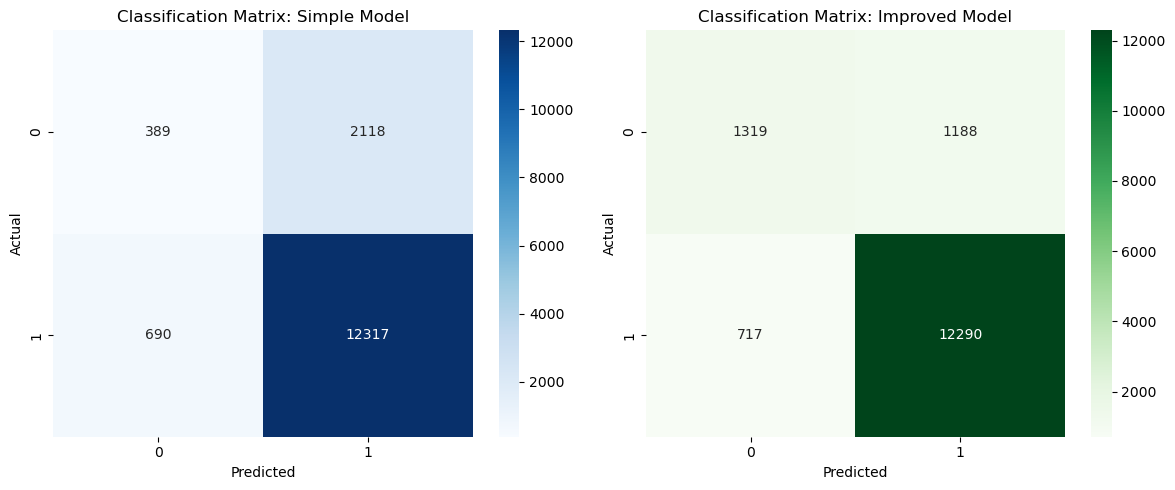

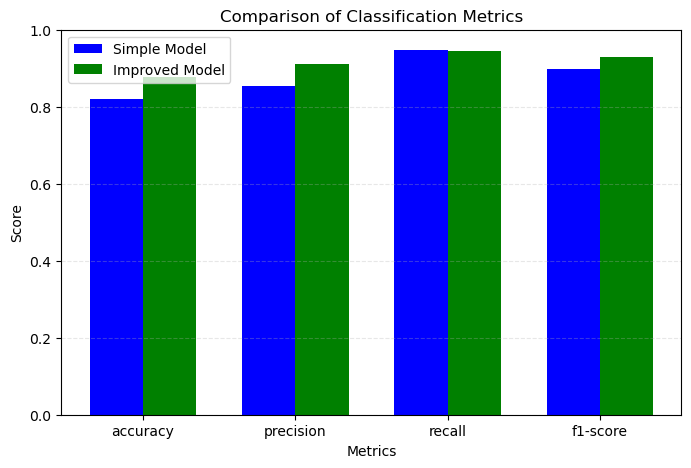

In [92]:
# Define true labels and predictions
y_true = df["AffordableDwelling"]
y_pred_simple = df["SimpleModelPrediction"]
y_pred_improved = df["ImprovedModelPrediction"]

# Compute confusion matrices
conf_matrix_simple = confusion_matrix(y_true, y_pred_simple)
conf_matrix_improved = confusion_matrix(y_true, y_pred_improved)

# Generate classification reports
report_simple = classification_report(y_true, y_pred_simple, output_dict=True)
report_improved = classification_report(y_true, y_pred_improved, output_dict=True)

# Display classification reports
print("=== Classification Report: Simple Model ===\n", classification_report(y_true, y_pred_simple))
print("\n=== Classification Report: Improved Model ===\n", classification_report(y_true, y_pred_improved))

# Visualize classification matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Simple Model Classification Matrix
sns.heatmap(conf_matrix_simple, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Classification Matrix: Simple Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Improved Model Classification Matrix
sns.heatmap(conf_matrix_improved, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Classification Matrix: Improved Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Visualize classification metrics using bar charts
metrics = ["accuracy", "precision", "recall", "f1-score"]
labels = ["Simple Model", "Improved Model"]

# Extract metric values
simple_metrics = [report_simple["accuracy"], report_simple["1"]["precision"], report_simple["1"]["recall"], report_simple["1"]["f1-score"]]
improved_metrics = [report_improved["accuracy"], report_improved["1"]["precision"], report_improved["1"]["recall"], report_improved["1"]["f1-score"]]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, simple_metrics, width, label="Simple Model", color="blue")
ax.bar(x + width/2, improved_metrics, width, label="Improved Model", color="green")

ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Comparison of Classification Metrics")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

# Evaluation

## Simple Model vs Improved Model

### Simple Model
Our assignment was pretty clear: create a benchmark classification model using simple rules based on the findings of our data understanding.

This is exactly what we did for our first benchmark classification model. We made a model based on one rule that, for us, was pretty obvious:  

> If I live in a certain enclave, could it rule my house out for affordability (yes or no) based on predictions and data understanding?

We analyzed the data and concluded that this was possible, even with a high accuracy rate. Certain enclaves could be ruled out for affordability since those enclaves had a low affordability rate based on our calculations with the given factors.  

We were happy with the outcome of our prediction, which resulted in:  
- **Accuracy rate:** *0.819*  
- **Error rate:** *0.181*  

These numbers are generally very good, and we thought so too. However, since we were eager to advance our model, we decided to improve it by adding more rules to increase accuracy and decrease the error rate.  

### Steps We Took
Before adding more rules, we needed to delve deeper into our dataset to better understand the relationships within it.  

We found that:  
- **Affordability varies by enclave.** Some enclaves have a high affordability rate, while others have a low rate. We set thresholds to determine whether an enclave had a high chance of being affordable or not.  
- **Reals influence affordability** based on their property distribution.  
- **Property size affects affordability.** Particularly in specific reals, small properties in mostly unaffordable enclaves could still be affordable.  

After carefully considering these insights, we decided to implement them in our new benchmark classification model.


### Improved Model

For our improved model we implemented these rules and it turned out great.
We added the rules step by step to avoid confusion, errors and improved our understanding. As you can see in the model itself we wrote down our explenation of our rules, and why we implemented them. We thought by adding these steps not only the accuracy would improved but also the precision and recall. 
The precision did indeed improve:
- **Class 0: 80.56% improvement**
- **Class 1: 7.06% improvement**

However, the recall did not improve as much as we initially expected, possibly due to certain factors we overlooked. Despite this, we were not overly concerned since the recall percentages were already quite high.

We are extremely pleased with the outcome of our improved model and the high accuracy it achieved. Through this process, we broadend our understanding of building benchmark models and effectively articulating our findings.

The improvements reflected in the classification matrix further demonstrate our enhanced comprehension of the dataset and the benchmark model itself.

### Decision Tree Evaluation

To supplement our rule-based models, we trained a Decision Tree classifier using two engineered features: `IsAffordable` (based on the monthly payment threshold) and `EnclaveCategory` (based on enclave-level affordability rates).

We split the dataset into training and test sets (80/20), trained the model, and evaluated its performance using a classification report:



In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Select features to train with
features = ['IsAffordable', 'EnclaveCategory'] 
X = df[features]
X = pd.get_dummies(X)
y = df["AffordableDwelling"]

# Split into training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report: Decision Tree")
print(classification_report(y_test, y_pred))


Classification Report: Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00      2605

    accuracy                           1.00      3103
   macro avg       1.00      1.00      1.00      3103
weighted avg       1.00      1.00      1.00      3103

